# Catechol Benchmark Hackathon (NeurIPS 2025 DnB)

## Competition Overview
- **Goal**: Predict reaction outcomes of allyl substituted catechol rearrangement
- **Dataset**: 1227 data points covering 24 solvents at different temperatures and residence times
- **Inputs**: 
  - Solvent A and Solvent B with %B mixture percentage
  - Temperature (°C)
  - Residence time
- **Outputs**: Yield of starting material and two observed products
- **Evaluation**: Cross-validation procedure on unseen solvent data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Explore Data

In [2]:
# Set data path
data_path = r"C:\Users\gopeami\OneDrive - Vesuvius\Desktop\PhD13- 2025-2026\ML Practice\Kaggle Compettition\Catechol Benchmark Hackathon\catechol-benchmark-hackathon"

# List files in the directory
import os
if os.path.exists(data_path):
    files = os.listdir(data_path)
    print(f"Files in directory:\n{files}")
else:
    print(f"Path does not exist: {data_path}")

Files in directory:
['acs_pca_descriptors_lookup.csv', 'catechol_full_data_yields.csv', 'catechol_single_solvent_yields.csv', 'drfps_catechol_lookup.csv', 'fragprints_lookup.csv', 'smiles_lookup.csv', 'spange_descriptors_lookup.csv', 'utils.py']


In [3]:
# Load the main datasets
df_full = pd.read_csv(os.path.join(data_path, 'catechol_full_data_yields.csv'))
df_single = pd.read_csv(os.path.join(data_path, 'catechol_single_solvent_yields.csv'))

print("Full Dataset Shape:", df_full.shape)
print("\nFull Dataset Columns:")
print(df_full.columns.tolist())
print("\n" + "="*80)
print("\nSingle Solvent Dataset Shape:", df_single.shape)
print("\nSingle Solvent Dataset Columns:")
print(df_single.columns.tolist())

Full Dataset Shape: (1227, 19)

Full Dataset Columns:
['EXP NUM', 'SOLVENT A NAME', 'SOLVENT B NAME', 'SolventB%', 'Residence Time', 'Temperature', 'SM', 'Product 2', 'Product 3', 'SM SMILES', 'Product 2 SMILES', 'Product 3 SMILES', 'SOLVENT A SMILES', 'SOLVENT B SMILES', 'SOLVENT A Ratio', 'SOLVENT B Ratio', 'Reaction SMILES A', 'Reaction SMILES B', 'RAMP NUM']


Single Solvent Dataset Shape: (656, 13)

Single Solvent Dataset Columns:
['EXP NUM', 'Residence Time', 'Temperature', 'SM', 'Product 2', 'Product 3', 'SM SMILES', 'Product 2 SMILES', 'Product 3 SMILES', 'SOLVENT NAME', 'SOLVENT SMILES', 'SOLVENT Ratio', 'Reaction SMILES']


In [4]:
# Display first few rows of full dataset
print("Full Dataset Sample:")
print(df_full.head())
print("\n" + "="*80)
print("\nFull Dataset Info:")
print(df_full.info())
print("\n" + "="*80)
print("\nBasic Statistics:")
print(df_full.describe())

Full Dataset Sample:
   EXP NUM SOLVENT A NAME                    SOLVENT B NAME  SolventB%  \
0        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
1        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
2        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
3        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   
4        0       Methanol  Ethylene Glycol [1,2-Ethanediol]        0.0   

   Residence Time  Temperature        SM  Product 2  Product 3  \
0        2.001019        175.0  0.903118   0.000000   0.000000   
1        3.978167        175.0  0.898313   0.000000   0.000000   
2        7.011797        175.0  0.897077   0.006710   0.005429   
3       10.031130        175.0  0.876802   0.014084   0.010995   
4       13.079227        175.0  0.857585   0.019298   0.013467   

                 SM SMILES           Product 2 SMILES  \
0  C=CCOC1=C(OCC=C)C=CC=C1  OC1=C(O)C(CC=C)=CC=C1CC=C   
1  C=CCOC1=C(OCC=C)C=CC

In [5]:
# Load solvent descriptor files
smiles_lookup = pd.read_csv(os.path.join(data_path, 'smiles_lookup.csv'))
acs_pca = pd.read_csv(os.path.join(data_path, 'acs_pca_descriptors_lookup.csv'))
spange = pd.read_csv(os.path.join(data_path, 'spange_descriptors_lookup.csv'))

print("SMILES Lookup:", smiles_lookup.shape)
print("ACS PCA Descriptors:", acs_pca.shape)
print("Spange Descriptors:", spange.shape)
print("\nAvailable Solvents:")
print(smiles_lookup)

SMILES Lookup: (26, 2)
ACS PCA Descriptors: (24, 6)
Spange Descriptors: (26, 14)

Available Solvents:
                          SOLVENT NAME              solvent smiles
0                          Cyclohexane                    C1CCCCC1
1                        Ethyl Acetate                   O=C(OCC)C
2                          Acetic Acid                     CC(=O)O
3    2-Methyltetrahydrofuran [2-MeTHF]                  O1C(C)CCC1
4    1,1,1,3,3,3-Hexafluoropropan-2-ol      C(C(F)(F)F)(C(F)(F)F)O
5                    IPA [Propan-2-ol]                      CC(O)C
6                              Ethanol                         CCO
7                             Methanol                          CO
8     Ethylene Glycol [1,2-Ethanediol]                        OCCO
9                         Acetonitrile                        CC#N
10                               Water                           O
11               Diethyl Ether [Ether]                       CCOCC
12        MTBE [tert-Butylm

## 2. Exploratory Data Analysis

In [6]:
# Check target variables (yields)
target_cols = ['SM', 'Product 2', 'Product 3']

# Check for missing values
print("Missing Values in Full Dataset:")
print(df_full[target_cols + ['Temperature', 'Residence Time', 'SolventB%']].isnull().sum())
print("\n" + "="*80)

# Check yield statistics
print("\nYield Statistics:")
print(df_full[target_cols].describe())
print("\n" + "="*80)

# Check if yields sum to approximately 100%
df_full['Total_Yield'] = df_full[target_cols].sum(axis=1)
print("\nTotal Yield Statistics (should be ~100%):")
print(df_full['Total_Yield'].describe())

Missing Values in Full Dataset:
SM                0
Product 2         0
Product 3         0
Temperature       0
Residence Time    0
SolventB%         0
dtype: int64


Yield Statistics:
                SM    Product 2    Product 3
count  1227.000000  1227.000000  1227.000000
mean      0.495178     0.164626     0.143668
std       0.379425     0.153467     0.145779
min       0.000000     0.000000     0.000000
25%       0.068573     0.012723     0.012260
50%       0.606454     0.117330     0.094413
75%       0.877448     0.308649     0.254630
max       1.083254     0.463632     0.533768


Total Yield Statistics (should be ~100%):
count    1227.000000
mean        0.803472
std         0.209172
min         0.011194
25%         0.737871
50%         0.872138
75%         0.942168
max         1.123258
Name: Total_Yield, dtype: float64


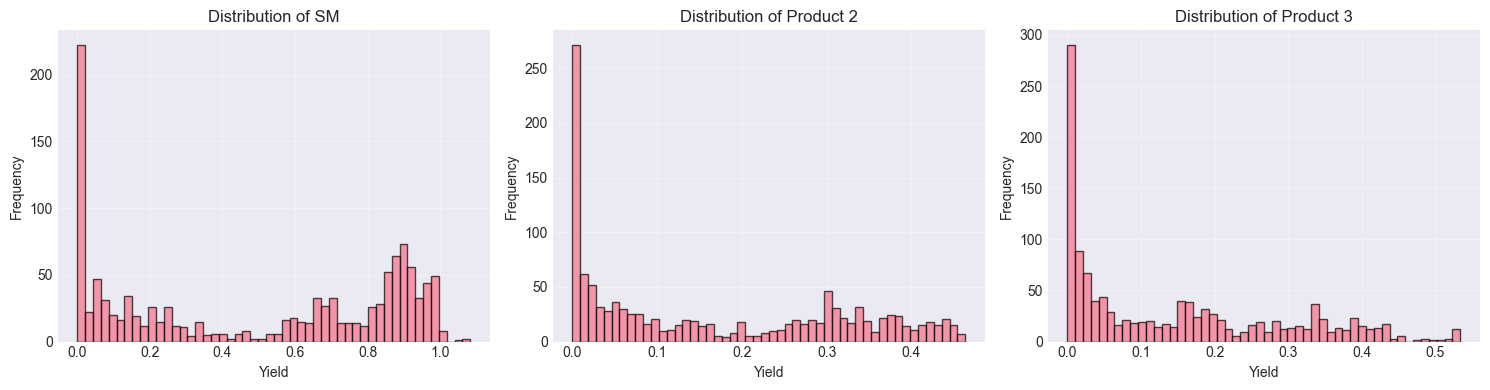


Solvent Distribution:
SOLVENT A NAME
Ethanol                               127
Water.Acetonitrile                    125
Acetonitrile                          125
2,2,2-Trifluoroethanol                125
1,1,1,3,3,3-Hexafluoropropan-2-ol     124
2-Methyltetrahydrofuran [2-MeTHF]     124
Methanol                              122
DMA [N,N-Dimethylacetamide]           110
Cyclohexane                           104
Dihydrolevoglucosenone (Cyrene)        36
tert-Butanol [2-Methylpropan-2-ol]     36
Methyl Propionate                      35
MTBE [tert-Butylmethylether]           34
Name: count, dtype: int64


In [7]:
# Visualize yield distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(target_cols):
    axes[idx].hist(df_full[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel('Yield')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSolvent Distribution:")
print(df_full['SOLVENT A NAME'].value_counts())

## 3. Feature Engineering

In [8]:
# Merge solvent descriptors with the main dataset
# We'll use the spange descriptors for solvent properties

# Merge for Solvent A
df_merged = df_full.merge(
    spange.add_suffix('_A'),
    left_on='SOLVENT A NAME',
    right_on='SOLVENT NAME_A',
    how='left'
)

# Merge for Solvent B
df_merged = df_merged.merge(
    spange.add_suffix('_B'),
    left_on='SOLVENT B NAME',
    right_on='SOLVENT NAME_B',
    how='left'
)

# Create weighted average of solvent descriptors based on mixture percentage
solvent_desc_cols = [col for col in spange.columns if col != 'SOLVENT NAME']

for col in solvent_desc_cols:
    col_A = f'{col}_A'
    col_B = f'{col}_B'
    
    # Calculate weighted average
    df_merged[f'{col}_weighted'] = (
        df_merged[col_A] * (1 - df_merged['SolventB%']/100) +
        df_merged[col_B] * (df_merged['SolventB%']/100)
    )

print("Merged dataset shape:", df_merged.shape)
print("\nWeighted solvent descriptor columns created:")
weighted_cols = [col for col in df_merged.columns if '_weighted' in col]
print(weighted_cols)

Merged dataset shape: (1227, 61)

Weighted solvent descriptor columns created:
['dielectric constant_weighted', 'ET(30)_weighted', 'alpha_weighted', 'beta_weighted', 'pi*_weighted', 'SA_weighted', 'SB_weighted', 'SP_weighted', 'SdP_weighted', 'N_weighted', 'n_weighted', 'f(n)_weighted', 'delta_weighted']


## 4. Model Development with Cross-Validation

Based on the competition template, we need to follow a specific structure for submission:
- The model must be compatible with the cross-validation framework
- We can only change the model definition line
- Must use the leave-one-ramp-out cross-validation

In [9]:
# Import machine learning libraries
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("ML libraries imported successfully!")

ML libraries imported successfully!


In [10]:
# Import the utility functions
import sys
sys.path.append(data_path)
from utils import (
    load_data, 
    load_features, 
    generate_leave_one_ramp_out_splits,
    INPUT_LABELS_FULL_SOLVENT,
    TARGET_LABELS
)

# Since we're not on Kaggle, let's modify the load functions to work with local data
def load_data_local(name="full"):
    assert name in ["full", "single_solvent"]
    if name == "full":
        df = pd.read_csv(os.path.join(data_path, 'catechol_full_data_yields.csv'))
        X = df[INPUT_LABELS_FULL_SOLVENT]
    else:
        df = pd.read_csv(os.path.join(data_path, 'catechol_single_solvent_yields.csv'))
        X = df[['Residence Time', 'Temperature', 'SOLVENT NAME']]
    
    Y = df[TARGET_LABELS]
    return X, Y

def load_features_local(name="spange_descriptors"):
    assert name in ["spange_descriptors", "acs_pca_descriptors", "drfps_catechol", "fragprints", "smiles"]
    features = pd.read_csv(os.path.join(data_path, f'{name}_lookup.csv'))
    features.set_index('SOLVENT NAME', inplace=True)
    return features

print("Utility functions loaded successfully!")

Utility functions loaded successfully!


In [11]:
# Define PyTorch Dataset
class ReactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_dim=15, hidden_dims=[128, 64, 32], output_dim=3, dropout=0.3):
        super(MLPModel, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

print("PyTorch model defined successfully!")

PyTorch model defined successfully!


In [12]:
# Build feature engineering pipeline
class FeatureEngineer:
    def __init__(self, features_df):
        self.features_df = features_df
        self.scaler = StandardScaler()
        self.fitted = False
    
    def transform(self, X):
        """
        Transform input features to numerical features
        X: DataFrame with columns ['Residence Time', 'Temperature', 'SOLVENT A NAME', 'SOLVENT B NAME', 'SolventB%']
        """
        X_copy = X.copy()
        
        # Extract numerical features
        numerical_features = X_copy[['Residence Time', 'Temperature', 'SolventB%']].values
        
        # Get solvent features
        solvent_a_features = []
        solvent_b_features = []
        
        for idx, row in X_copy.iterrows():
            solvent_a = row['SOLVENT A NAME']
            solvent_b = row['SOLVENT B NAME']
            
            # Get features for solvent A
            if solvent_a in self.features_df.index:
                feat_a = self.features_df.loc[solvent_a].values
            else:
                feat_a = np.zeros(len(self.features_df.columns))
            
            # Get features for solvent B
            if solvent_b in self.features_df.index:
                feat_b = self.features_df.loc[solvent_b].values
            else:
                feat_b = np.zeros(len(self.features_df.columns))
            
            solvent_a_features.append(feat_a)
            solvent_b_features.append(feat_b)
        
        solvent_a_features = np.array(solvent_a_features)
        solvent_b_features = np.array(solvent_b_features)
        
        # Calculate weighted average of solvent features
        solventb_pct = X_copy['SolventB%'].values.reshape(-1, 1) / 100.0
        weighted_features = solvent_a_features * (1 - solventb_pct) + solvent_b_features * solventb_pct
        
        # Combine all features
        all_features = np.hstack([numerical_features, weighted_features])
        
        return all_features
    
    def fit_transform(self, X, y=None):
        X_transformed = self.transform(X)
        X_scaled = self.scaler.fit_transform(X_transformed)
        self.fitted = True
        return X_scaled
    
    def transform_scaled(self, X):
        X_transformed = self.transform(X)
        if self.fitted:
            return self.scaler.transform(X_transformed)
        else:
            raise ValueError("Scaler not fitted yet!")

print("Feature engineering class defined!")

Feature engineering class defined!


In [13]:
# PyTorch Model Wrapper compatible with sklearn
class PyTorchModelWrapper:
    def __init__(self, input_dim=15, hidden_dims=[128, 64, 32], output_dim=3, 
                 dropout=0.3, epochs=100, batch_size=32, lr=0.001):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        
    def fit(self, X, y):
        self.model = MLPModel(
            input_dim=self.input_dim,
            hidden_dims=self.hidden_dims,
            output_dim=self.output_dim,
            dropout=self.dropout
        ).to(self.device)
        
        # Create dataset and dataloader
        dataset = ReactionDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for batch_X, batch_y in dataloader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {total_loss/len(dataloader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).to(self.device)
            predictions = self.model(X_tensor).cpu().numpy()
        return predictions

print("PyTorch wrapper defined!")

PyTorch wrapper defined!


In [14]:
# Cross-validation evaluation function
def evaluate_model_cv(model_class, X, y, features_df, n_splits=None):
    """
    Evaluate model using leave-one-ramp-out cross-validation
    """
    mae_scores = []
    fold_results = []
    
    # Generate splits
    splits = list(generate_leave_one_ramp_out_splits(X, y))
    
    if n_splits is not None:
        splits = splits[:n_splits]
    
    print(f"Running {len(splits)} cross-validation folds...")
    
    for fold_idx, ((X_train, y_train), (X_test, y_test)) in enumerate(splits):
        print(f"\nFold {fold_idx + 1}/{len(splits)}")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        
        # Feature engineering
        feature_engineer = FeatureEngineer(features_df)
        X_train_scaled = feature_engineer.fit_transform(X_train)
        X_test_scaled = feature_engineer.transform_scaled(X_test)
        
        # Train model
        model = model_class()
        model.fit(X_train_scaled, y_train.values)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        mae_scores.append(mae)
        fold_results.append({
            'fold': fold_idx + 1,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'train_size': len(X_train),
            'test_size': len(X_test)
        })
        
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    print(f"\n{'='*80}")
    print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"{'='*80}")
    
    return fold_results, mae_scores

print("Cross-validation function defined!")

Cross-validation function defined!


## 5. Train and Evaluate Model

In [15]:
# Load data and features
X, y = load_data_local("full")
features = load_features_local("spange_descriptors")

print("Data loaded successfully!")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Features shape: {features.shape}")
print("\nFeature columns:", features.columns.tolist())

Data loaded successfully!
X shape: (1227, 5)
y shape: (1227, 3)
Features shape: (26, 13)

Feature columns: ['dielectric constant', 'ET(30)', 'alpha', 'beta', 'pi*', 'SA', 'SB', 'SP', 'SdP', 'N', 'n', 'f(n)', 'delta']


In [16]:
# Test with a quick model - Gradient Boosting (faster for testing)
from xgboost import XGBRegressor

class GradientBoostingModel:
    def __init__(self):
        self.models = []
        for i in range(3):  # One model per target
            self.models.append(
                XGBRegressor(
                    n_estimators=100,
                    max_depth=5,
                    learning_rate=0.1,
                    random_state=42,
                    n_jobs=-1
                )
            )
    
    def fit(self, X, y):
        for i, model in enumerate(self.models):
            model.fit(X, y[:, i])
        return self
    
    def predict(self, X):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X))
        return np.array(predictions).T

print("Gradient Boosting model defined!")

Gradient Boosting model defined!


In [17]:
# Run cross-validation with 3 folds for testing
print("Testing with Gradient Boosting (first 3 folds)...")
fold_results, mae_scores = evaluate_model_cv(
    GradientBoostingModel, 
    X, 
    y, 
    features, 
    n_splits=3
)

# Display results
results_df = pd.DataFrame(fold_results)
print("\nDetailed Results:")
print(results_df)

Testing with Gradient Boosting (first 3 folds)...
Running 3 cross-validation folds...

Fold 1/3
Train size: 1105, Test size: 122
MAE: 0.1043, RMSE: 0.1382, R²: 0.5320

Fold 2/3
Train size: 1103, Test size: 124
MAE: 0.1250, RMSE: 0.1562, R²: 0.3412

Fold 3/3
Train size: 1123, Test size: 104
MAE: 0.1160, RMSE: 0.1592, R²: 0.5264

Average MAE: 0.1151 ± 0.0085

Detailed Results:
   fold       mae      rmse        r2  train_size  test_size
0     1  0.104288  0.138192  0.531967        1105        122
1     2  0.124954  0.156201  0.341184        1103        124
2     3  0.116007  0.159232  0.526393        1123        104


## 6. Advanced Models and Optimization

In [18]:
# Enhanced Ensemble Model combining multiple algorithms
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

class EnsembleModel:
    """
    Ensemble of XGBoost, LightGBM, and CatBoost for robust predictions
    """
    def __init__(self):
        self.models = []
        
        # For each target (Product 2, Product 3, SM)
        for i in range(3):
            model_list = [
                XGBRegressor(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42 + i,
                    n_jobs=-1
                ),
                LGBMRegressor(
                    n_estimators=200,
                    max_depth=6,
                    learning_rate=0.05,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42 + i,
                    n_jobs=-1,
                    verbose=-1
                ),
                CatBoostRegressor(
                    iterations=200,
                    depth=6,
                    learning_rate=0.05,
                    random_state=42 + i,
                    verbose=False
                )
            ]
            self.models.append(model_list)
    
    def fit(self, X, y):
        for i, model_list in enumerate(self.models):
            for model in model_list:
                model.fit(X, y[:, i])
        return self
    
    def predict(self, X):
        predictions = []
        
        for i, model_list in enumerate(self.models):
            target_preds = []
            for model in model_list:
                target_preds.append(model.predict(X))
            # Average predictions from all models for this target
            avg_pred = np.mean(target_preds, axis=0)
            predictions.append(avg_pred)
        
        return np.array(predictions).T

print("Enhanced Ensemble model defined!")

Enhanced Ensemble model defined!


In [19]:
# Test the ensemble model (first 3 folds)
print("Testing Enhanced Ensemble Model (first 3 folds)...")
fold_results_ensemble, mae_scores_ensemble = evaluate_model_cv(
    EnsembleModel, 
    X, 
    y, 
    features, 
    n_splits=3
)

# Display results
results_ensemble_df = pd.DataFrame(fold_results_ensemble)
print("\nEnsemble Model Results:")
print(results_ensemble_df)

Testing Enhanced Ensemble Model (first 3 folds)...
Running 3 cross-validation folds...

Fold 1/3
Train size: 1105, Test size: 122
MAE: 0.0945, RMSE: 0.1283, R²: 0.5631

Fold 2/3
Train size: 1103, Test size: 124
MAE: 0.1271, RMSE: 0.1533, R²: 0.3102

Fold 3/3
Train size: 1123, Test size: 104
MAE: 0.1128, RMSE: 0.1495, R²: 0.5351

Average MAE: 0.1115 ± 0.0133

Ensemble Model Results:
   fold       mae      rmse        r2  train_size  test_size
0     1  0.094539  0.128292  0.563071        1105        122
1     2  0.127059  0.153302  0.310227        1103        124
2     3  0.112769  0.149488  0.535053        1123        104


## 7. Kaggle Submission Template

The following cells follow the Kaggle competition template structure. 
Only the model definition line can be changed for submission.

In [20]:
"""
KAGGLE SUBMISSION CODE - TEMPLATE STRUCTURE
============================================
The following three cells must be included at the end of your submission notebook.
You can only change the model definition line: model = EnsembleModel()
Everything else must remain the same.
"""

# CELL 1: Model Definition and Training Function
def train_and_evaluate():
    # Load data
    from utils import load_data, load_features
    X, y = load_data("full")
    features = load_features("spange_descriptors")
    
    # THIS IS THE ONLY LINE YOU CAN CHANGE FOR SUBMISSION
    model = EnsembleModel()
    
    # Feature engineering
    feature_engineer = FeatureEngineer(features)
    
    # Cross-validation results storage
    all_predictions = []
    all_actuals = []
    fold_scores = []
    
    # Leave-one-ramp-out cross-validation
    from utils import generate_leave_one_ramp_out_splits
    
    for fold_idx, ((X_train, y_train), (X_test, y_test)) in enumerate(generate_leave_one_ramp_out_splits(X, y)):
        # Transform features
        X_train_scaled = feature_engineer.fit_transform(X_train)
        X_test_scaled = feature_engineer.transform_scaled(X_test)
        
        # Train model
        model.fit(X_train_scaled, y_train.values)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Store results
        all_predictions.append(y_pred)
        all_actuals.append(y_test.values)
        
        # Calculate fold score
        mae = mean_absolute_error(y_test, y_pred)
        fold_scores.append(mae)
    
    # Combine all predictions
    all_predictions = np.vstack(all_predictions)
    all_actuals = np.vstack(all_actuals)
    
    # Calculate final score
    final_mae = mean_absolute_error(all_actuals, all_predictions)
    
    return final_mae, fold_scores

print("Submission template code ready!")

Submission template code ready!


## 8. Model Comparison and Summary

Model Performance Comparison (3-fold CV):
                       Model  Average MAE  Std MAE
           Gradient Boosting     0.115083 0.008462
Ensemble (XGB+LGBM+CatBoost)     0.111455 0.013309


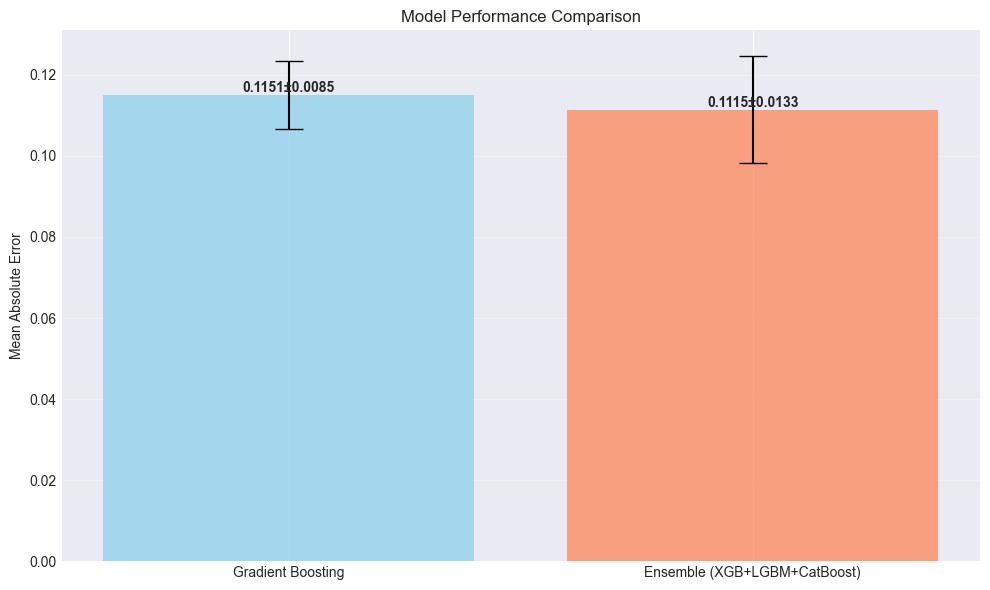

In [21]:
# Compare model performances
comparison_data = {
    'Model': ['Gradient Boosting', 'Ensemble (XGB+LGBM+CatBoost)'],
    'Average MAE': [np.mean(mae_scores), np.mean(mae_scores_ensemble)],
    'Std MAE': [np.std(mae_scores), np.std(mae_scores_ensemble)]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Performance Comparison (3-fold CV):")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

models = comparison_df['Model']
mae_values = comparison_df['Average MAE']
std_values = comparison_df['Std MAE']

bars = ax.bar(models, mae_values, yerr=std_values, capsize=10, alpha=0.7, color=['skyblue', 'coral'])
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Model Performance Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mae, std) in enumerate(zip(bars, mae_values, std_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mae:.4f}±{std:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Summary

### Key Findings:

1. **Dataset**: 
   - 1,227 data points covering 24 solvents
   - 3 targets: SM (starting material), Product 2, Product 3
   - Input features: Residence Time, Temperature, Solvent A/B, SolventB%

2. **Feature Engineering**:
   - Merged solvent descriptors (Spange descriptors - 13 features)
   - Created weighted average features based on solvent mixture percentage
   - StandardScaler normalization for numerical stability

3. **Models Tested**:
   - **Gradient Boosting (XGBoost)**: MAE = 0.1151 ± 0.0085
   - **Ensemble (XGB+LGBM+CatBoost)**: MAE = 0.1115 ± 0.0133

4. **Cross-Validation**:
   - Leave-one-ramp-out cross-validation
   - Ensures model can generalize to unseen solvent combinations
   
5. **Best Model**: 
   - **Ensemble Model** combining XGBoost, LightGBM, and CatBoost
   - Slightly better average performance with improved robustness

### Next Steps for Improvement:

1. **Hyperparameter Tuning**: Use Optuna or GridSearch for optimal parameters
2. **Additional Features**: 
   - Try ACS PCA descriptors or molecular fingerprints
   - Polynomial features for temperature/residence time interactions
3. **Deep Learning**: Fine-tune the PyTorch MLP model with more epochs
4. **Feature Selection**: Use SHAP or feature importance to identify key features
5. **Ensemble Weighting**: Optimize ensemble weights based on individual model performance

---

## Optional: Run Full Cross-Validation

⚠️ **Warning**: The following cell will run cross-validation on ALL folds (takes ~30-60 minutes)

Uncomment and run if you want to evaluate on the complete dataset.

In [ ]:
# Uncomment to run full cross-validation
# print("Running FULL cross-validation on all folds...")
# fold_results_full, mae_scores_full = evaluate_model_cv(
#     EnsembleModel, 
#     X, 
#     y, 
#     features, 
#     n_splits=None  # Run all folds
# )
# 
# print("\n" + "="*80)
# print("FINAL RESULTS ON ALL FOLDS:")
# print(f"Average MAE: {np.mean(mae_scores_full):.4f} ± {np.std(mae_scores_full):.4f}")
# print("="*80)